In [154]:
import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [155]:
dataframe = pd.read_csv('heart.csv')
display(dataframe.head())

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [156]:
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
dataframe_encoded = pd.get_dummies(dataframe, columns=categorical_columns, drop_first=True)

display(dataframe_encoded.head())

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


In [157]:
from scipy.stats import ttest_ind

heart_disease_yes = dataframe[dataframe['HeartDisease'] == 1]
heart_disease_no = dataframe[dataframe['HeartDisease'] == 0]

numerical_columns = dataframe.select_dtypes(include=[np.number]).columns

ttest_results = {}
for column in numerical_columns:
    t_stat, p_value = ttest_ind(heart_disease_yes[column].dropna(), heart_disease_no[column].dropna())
    ttest_results[column] = {'t_stat': t_stat, 'p_value': p_value}

for column, result in ttest_results.items():
    print(f"Column: {column}, t-statistic: {result['t_stat']}, p-value: {result['p_value']}")

Column: Age, t-statistic: 8.897234373161165, p-value: 3.0079532400497047e-18
Column: RestingBP, t-statistic: 3.275244705228324, p-value: 0.0010953145851724392
Column: Cholesterol, t-statistic: -7.242908595426182, p-value: 9.308308883532983e-13
Column: FastingBS, t-statistic: 8.395149993293485, p-value: 1.7535980103299488e-16
Column: MaxHR, t-statistic: -13.22548998290478, p-value: 1.1377859840278097e-36
Column: Oldpeak, t-statistic: 13.364696790867978, p-value: 2.3907724240589574e-37
Column: HeartDisease, t-statistic: inf, p-value: 0.0


c:\Users\kaden\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


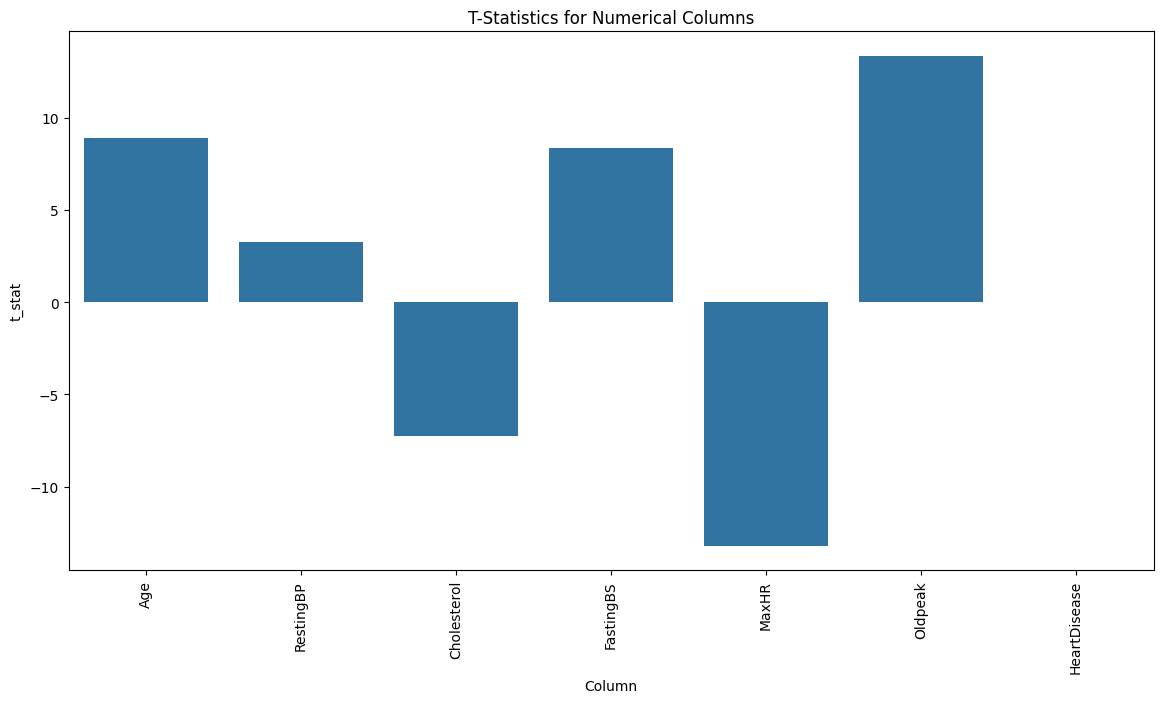

In [158]:
t_stats = [result['t_stat'] for result in ttest_results.values()]
columns = list(ttest_results.keys())

ttest_df = pd.DataFrame({
    'Column': columns,
    't_stat': t_stats
})

plt.figure(figsize=(14, 7))
sns.barplot(x='Column', y='t_stat', data=ttest_df)
plt.xticks(rotation=90)
plt.title('T-Statistics for Numerical Columns')
plt.show()


c:\Users\kaden\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


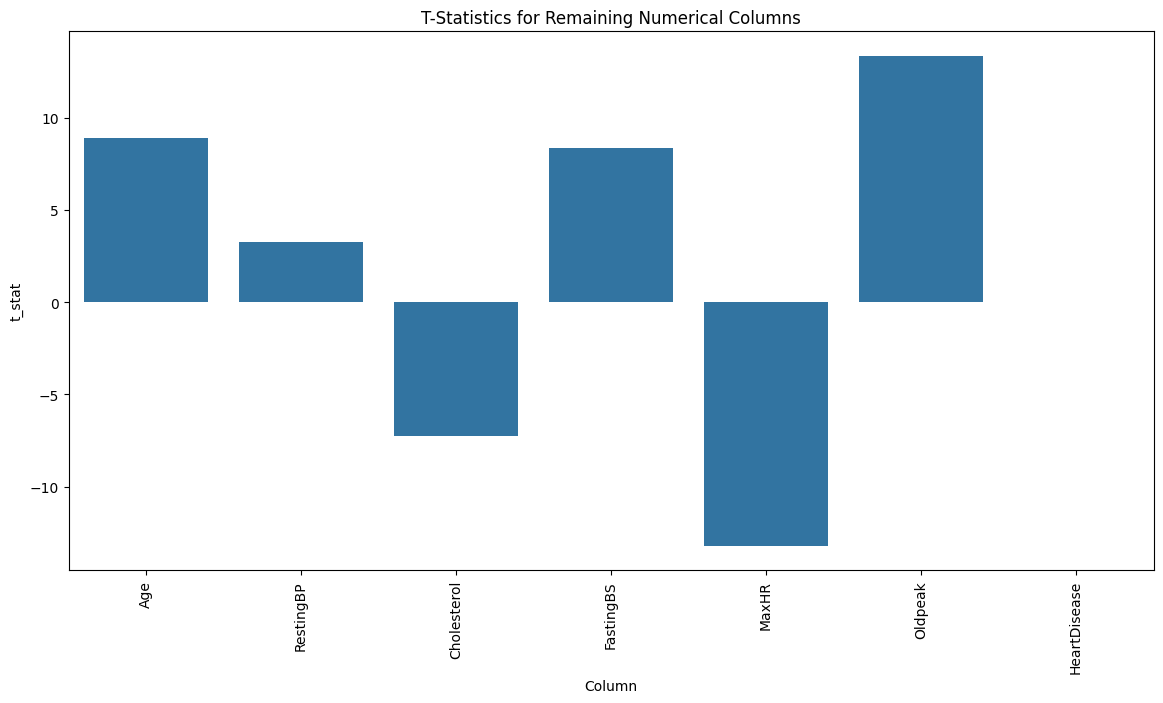

In [159]:

numerical_columns = dataframe_encoded.select_dtypes(include=[np.number]).columns

remaining_ttest_results = {}
for column in numerical_columns:
    t_stat, p_value = ttest_ind(
        dataframe_encoded[dataframe_encoded['HeartDisease'] == 1][column].dropna(),
        dataframe_encoded[dataframe_encoded['HeartDisease'] == 0][column].dropna()
    )
    remaining_ttest_results[column] = {'t_stat': t_stat, 'p_value': p_value}

remaining_t_stats = [result['t_stat'] for result in remaining_ttest_results.values()]
remaining_columns = list(remaining_ttest_results.keys())

remaining_ttest_df = pd.DataFrame({
    'Column': remaining_columns,
    't_stat': remaining_t_stats
})

plt.figure(figsize=(14, 7))
sns.barplot(x='Column', y='t_stat', data=remaining_ttest_df)
plt.xticks(rotation=90)
plt.title('T-Statistics for Remaining Numerical Columns')
plt.show()

In [160]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score
from scipy.stats import uniform

def filter_columns_by_t_stat(threshold, remaining_numerical_columns, remaining_t_stats):
    return [col for col, stat in zip(remaining_numerical_columns, remaining_t_stats) 
            if abs(stat) >= threshold]

best_score = -np.inf
best_params = None
thresholdResults = {}
t_stat_thresholds = range(0, 10,1)
best_threshold = None

for threshold in t_stat_thresholds:
    selected_columns = filter_columns_by_t_stat(
        threshold, 
        remaining_columns, 
        remaining_t_stats
    )
    
    if not selected_columns:
        print(f"No columns selected for threshold {threshold}")
        continue
    X = dataframe_encoded[selected_columns].drop(columns=['HeartDisease'])
    y = dataframe['HeartDisease']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    dt = DecisionTreeClassifier(random_state=42)
    param_dist = {
        'max_depth': [None] + list(range(1, 51)),
    }
    
    random_search = RandomizedSearchCV(
        dt, 
        param_distributions=param_dist,
        n_iter=100,
        cv=5,
        verbose=1,
        n_jobs=-1,
        random_state=42,
        scoring='f1'
    )
    random_search.fit(X_train, y_train)
    
    dt = DecisionTreeClassifier(random_state=42, **random_search.best_params_)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    
    thresholdResults[threshold] = {
        "score": f1,
        "params": random_search.best_params_,
        "n_features": len(selected_columns)
    }
    
    if f1 > best_score:
        best_score = f1
        best_params = random_search.best_params_
        best_threshold = threshold

print(f"Best threshold: {best_threshold}")
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

selected_columns = filter_columns_by_t_stat(
    best_threshold,
    remaining_columns,
    remaining_t_stats
)

X = dataframe_encoded[selected_columns].drop(columns=['HeartDisease'])
y = dataframe['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

dt = DecisionTreeClassifier(random_state=42, **best_params)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
final_f1 = f1_score(y_test, y_pred)
print(f"Final F1 score: {final_f1}")


c:\Users\kaden\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 51 is smaller than n_iter=100. Running 51 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\kaden\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 51 is smaller than n_iter=100. Running 51 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 51 candidates, totalling 255 fits
Fitting 5 folds for each of 51 candidates, totalling 255 fits


c:\Users\kaden\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 51 is smaller than n_iter=100. Running 51 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\kaden\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 51 is smaller than n_iter=100. Running 51 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 51 candidates, totalling 255 fits
Fitting 5 folds for each of 51 candidates, totalling 255 fits


c:\Users\kaden\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 51 is smaller than n_iter=100. Running 51 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\kaden\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 51 is smaller than n_iter=100. Running 51 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 51 candidates, totalling 255 fits
Fitting 5 folds for each of 51 candidates, totalling 255 fits


c:\Users\kaden\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 51 is smaller than n_iter=100. Running 51 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\kaden\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 51 is smaller than n_iter=100. Running 51 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 51 candidates, totalling 255 fits
Fitting 5 folds for each of 51 candidates, totalling 255 fits


c:\Users\kaden\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 51 is smaller than n_iter=100. Running 51 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\kaden\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 51 is smaller than n_iter=100. Running 51 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 51 candidates, totalling 255 fits
Fitting 5 folds for each of 51 candidates, totalling 255 fits
Best threshold: 0
Best parameters: {'max_depth': 3}
Best score: 0.7817258883248731
Final F1 score: 0.7817258883248731


Final F1 score: 0.7817258883248731


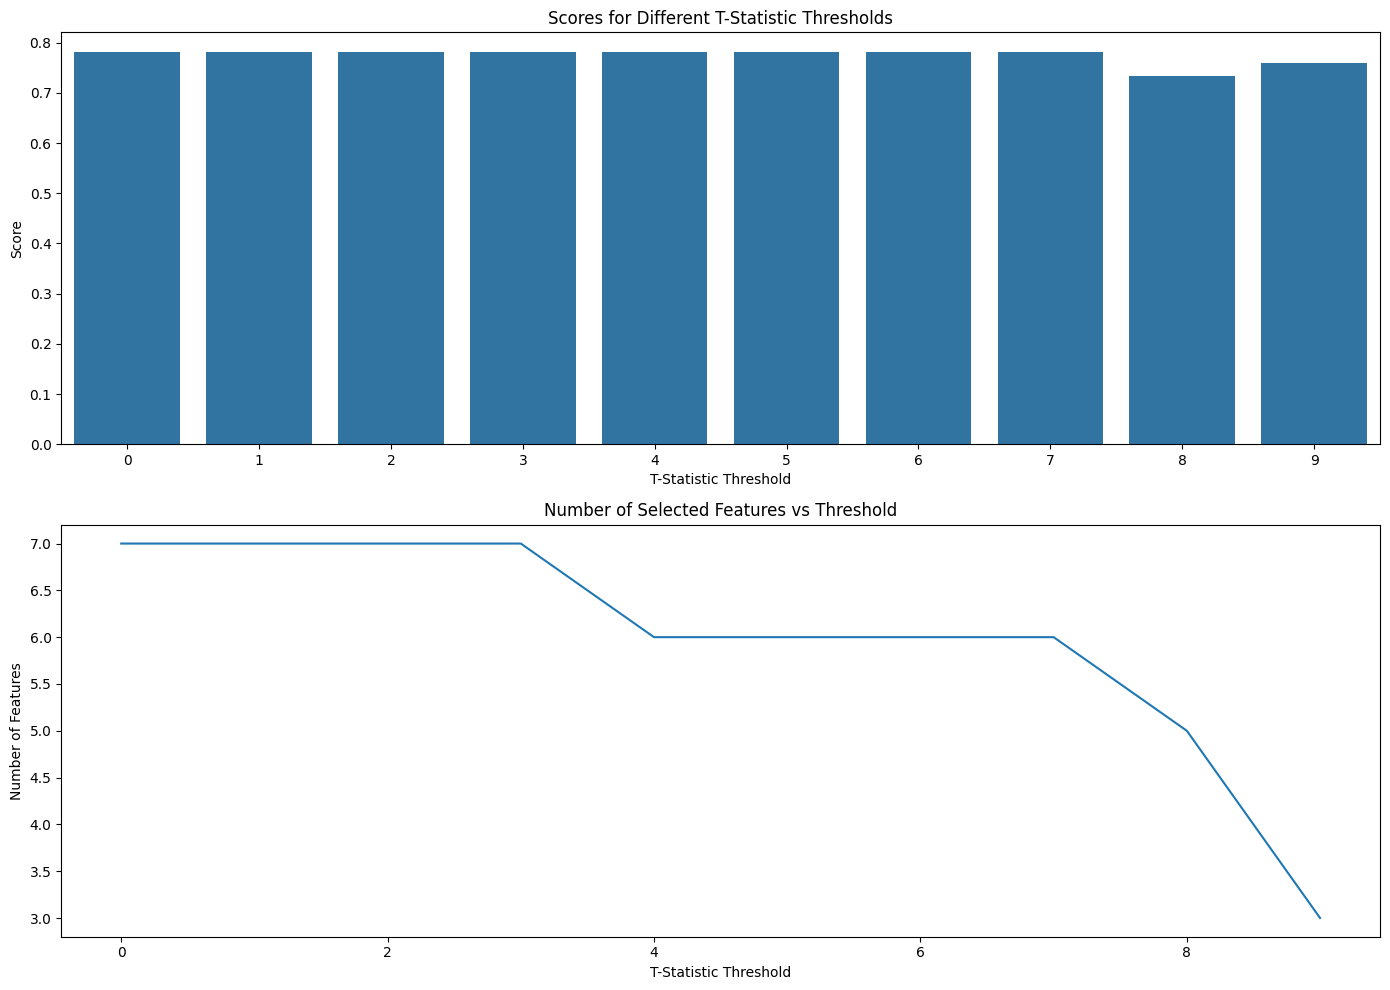

   Threshold     Score  N_Features            Params
0          0  0.781726           7  {'max_depth': 3}
1          1  0.781726           7  {'max_depth': 3}
2          2  0.781726           7  {'max_depth': 3}
3          3  0.781726           7  {'max_depth': 3}
4          4  0.781726           6  {'max_depth': 3}
5          5  0.781726           6  {'max_depth': 3}
6          6  0.781726           6  {'max_depth': 3}
7          7  0.781726           6  {'max_depth': 3}
8          8  0.734043           5  {'max_depth': 3}
9          9  0.759615           3  {'max_depth': 3}


In [161]:
selected_columns = filter_columns_by_t_stat(
    best_threshold,  
    numerical_columns,
    remaining_t_stats
)

X = dataframe_encoded[selected_columns].drop(columns=['HeartDisease'])
y = dataframe['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

best_dt = DecisionTreeClassifier(**best_params, random_state=42)
best_dt.fit(X_train, y_train)

y_pred = best_dt.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f"Final F1 score: {f1}")

results_df = pd.DataFrame({
    'Threshold': thresholdResults.keys(),
    'Score': [res['score'] for res in thresholdResults.values()],
    'N_Features': [res['n_features'] for res in thresholdResults.values()],
    'Params': [str(res['params']) for res in thresholdResults.values()]
})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

sns.barplot(x='Threshold', y='Score', data=results_df, ax=ax1)
ax1.set_title('Scores for Different T-Statistic Thresholds')
ax1.set_xlabel('T-Statistic Threshold')
ax1.set_ylabel('Score')

sns.lineplot(x='Threshold', y='N_Features', data=results_df, ax=ax2)
ax2.set_title('Number of Selected Features vs Threshold')
ax2.set_xlabel('T-Statistic Threshold')
ax2.set_ylabel('Number of Features')

plt.tight_layout()
plt.show()

print(results_df)




Testing architectures with 1 hidden layers for threshold 0
Architecture (43,): F1=0.7500
Architecture (46,): F1=0.7822
Architecture (45,): F1=0.7525
Architecture (24,): F1=0.7700
Architecture (46,): F1=0.7822
Architecture (10,): F1=0.7586
Architecture (39,): F1=0.7538
Architecture (26,): F1=0.7600
Architecture (9,): F1=0.7538
Architecture (19,): F1=0.7600

Testing architectures with 2 hidden layers for threshold 0
Architecture (24, 12): F1=0.6897
Architecture (30, 19): F1=0.6965
Architecture (8, 7): F1=0.7437
Architecture (48, 15): F1=0.7317
Architecture (22, 20): F1=0.7179
Architecture (29, 29): F1=0.7464
Architecture (37, 23): F1=0.7404
Architecture (14, 7): F1=0.7745
Architecture (39, 32): F1=0.7551
Architecture (38, 30): F1=0.7220

Testing architectures with 3 hidden layers for threshold 0
Architecture (26, 24, 23): F1=0.7094
Architecture (28, 28, 12): F1=0.7619
Architecture (21, 12, 7): F1=0.7245
Architecture (18, 18, 14): F1=0.7246
Architecture (8, 7, 7): F1=0.7653
Architecture 

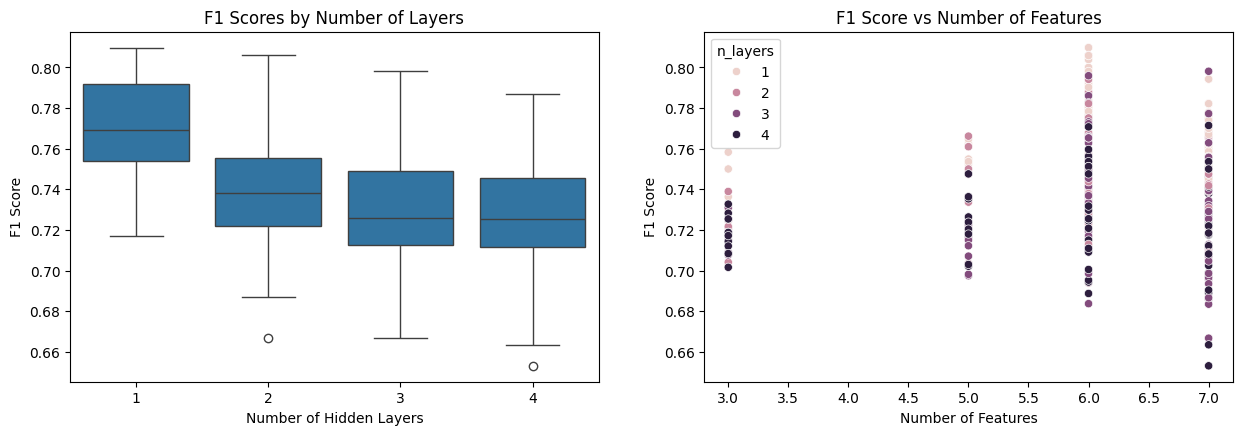


Summary by number of layers:
         f1_score                 n_iterations  \
             mean     std     max         mean   
n_layers                                         
1          0.7711  0.0219  0.8098       353.69   
2          0.7386  0.0258  0.8060      1236.77   
3          0.7313  0.0261  0.7981       965.72   
4          0.7266  0.0234  0.7867       754.11   

                                               architecture  
                                                   <lambda>  
n_layers                                                     
1         [(43,), (46,), (45,), (24,), (46,), (10,), (39...  
2         [(24, 12), (30, 19), (8, 7), (48, 15), (22, 20...  
3         [(26, 24, 23), (28, 28, 12), (21, 12, 7), (18,...  
4         [(27, 17, 15, 7), (32, 31, 14, 8), (17, 17, 16...  


In [162]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
import random
from datetime import datetime
import json

def filter_columns_by_t_stat(threshold, remaining_numerical_columns, remaining_t_stats):
    return [col for col, stat in zip(remaining_numerical_columns, remaining_t_stats) 
            if abs(stat) >= threshold]

def generate_random_architecture(n_layers, min_nodes=5, max_nodes=50):
    """Generate random layer sizes, decreasing as layers get deeper"""
    architecture = []
    current_max = max_nodes
    for _ in range(n_layers):
        nodes = random.randint(min_nodes, current_max)
        architecture.append(nodes)
        current_max = nodes  
    return tuple(architecture)

best_score = -np.inf
best_params = None
thresholdResults = {}
t_stat_thresholds = range(0, 10, 1)
best_threshold = None

max_layers = 4  
architectures_per_layer = 10 
all_results = []



for threshold in t_stat_thresholds:
    selected_columns = filter_columns_by_t_stat(
        threshold, 
        remaining_columns, 
        remaining_t_stats
    )
    
    if not selected_columns:
        print(f"No columns selected for threshold {threshold}")
        continue
        
    X = dataframe_encoded[selected_columns].drop(columns=['HeartDisease'])
    y = dataframe['HeartDisease']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    threshold_best_score = -np.inf
    threshold_best_architecture = None
    
    for n_layers in range(1, max_layers + 1):
        print(f"\nTesting architectures with {n_layers} hidden layers for threshold {threshold}")
        
        for attempt in range(architectures_per_layer):
            hidden_layer_sizes = generate_random_architecture(n_layers, min_nodes = len(selected_columns))
            
            mlp = MLPClassifier(
                hidden_layer_sizes=hidden_layer_sizes,
                max_iter=10000,
                random_state=42
            )
            
            try:
                mlp.fit(X_train_scaled, y_train)
                train_score = mlp.score(X_train_scaled, y_train)
                val_score = mlp.score(X_test_scaled, y_test)
                f1 = f1_score(y_test, mlp.predict(X_test_scaled))
                
                result = {
                    'threshold': threshold,
                    'n_layers': n_layers,
                    'architecture': hidden_layer_sizes,
                    'n_features': len(selected_columns),
                    'train_score': train_score,
                    'val_score': val_score,
                    'f1_score': f1,
                    'loss': mlp.loss_,
                    'n_iterations': mlp.n_iter_,
                }
                all_results.append(result)
                
                if f1 > threshold_best_score:
                    threshold_best_score = f1
                    threshold_best_architecture = hidden_layer_sizes
                
                print(f"Architecture {hidden_layer_sizes}: F1={f1:.4f}")
                
            except Exception as e:
                print(f"Failed with architecture {hidden_layer_sizes}: {str(e)}")
                continue
    
    thresholdResults[threshold] = {
        "score": threshold_best_score,
        "architecture": threshold_best_architecture,
        "n_features": len(selected_columns)
    }
    
    if threshold_best_score > best_score:
        best_score = threshold_best_score
        best_params = {'hidden_layer_sizes': threshold_best_architecture}
        best_threshold = threshold


print(f"\nBest threshold: {best_threshold}")
print(f"Best architecture: {best_params['hidden_layer_sizes']}")
print(f"Best score: {best_score}")

selected_columns = filter_columns_by_t_stat(
    best_threshold,
    remaining_columns,
    remaining_t_stats
)

X = dataframe_encoded[selected_columns].drop(columns=['HeartDisease'])
y = dataframe['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

best_mlp = MLPClassifier(
    hidden_layer_sizes=best_params['hidden_layer_sizes'],
    max_iter=10000,
    random_state=42
    
)
best_mlp.fit(X_train_scaled, y_train)

y_pred = best_mlp.predict(X_test_scaled)
final_f1 = f1_score(y_test, y_pred)
print(f"\nFinal F1 score: {final_f1}")

results_df = pd.DataFrame(all_results)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='n_layers', y='f1_score', data=results_df)
plt.title('F1 Scores by Number of Layers')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('F1 Score')

plt.subplot(2, 2, 2)
sns.scatterplot(x='n_features', y='f1_score', 
                hue='n_layers', data=results_df)
plt.title('F1 Score vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')


plt.show()

summary_df = results_df.groupby('n_layers').agg({
    'f1_score': ['mean', 'std', 'max'],
    'n_iterations': 'mean',
    'architecture': lambda x: list(x)
}).round(4)

print("\nSummary by number of layers:")
print(summary_df)

architecture_details = {
    'best_threshold': best_threshold,
    'best_architecture': best_params['hidden_layer_sizes'],
    'best_f1_score': best_score,
    'n_features': len(selected_columns),
    'selected_features': selected_columns
}

